In [92]:
# import important packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from matplotlib import rcParams
import warnings

warnings.filterwarnings("ignore")

# figure size in inches
rcParams["figure.figsize"] = 10, 6
np.random.seed(42)
plt.style.use('seaborn')

## 1. Load Dataset
- Load the `prime_indians_diabetes` dataset
- Check the first five samples. Are there any categorical features?
- Is this a classification or regression problem?
- Check the columns of the dataset

 There are  8 input variables and 1 output variable. Missing values are believed to be encoded with zero values. The variable names are as follows:

- Number of times pregnant.
- Plasma glucose concentration a 2 hours in an oral glucose tolerance test.
- Diastolic blood pressure (mm Hg).
- Triceps skinfold thickness (mm).
- 2-Hour serum insulin (mu U/ml).
- Body mass index (weight in kg/(height in m)^2).
- Diabetes pedigree function.
- Age (years).
- Class variable (0 or 1).

In [93]:
diabetes = pd.read_csv('data/pima_indians_diabetes.csv')
diabetes.head()

,time_pregnant_no,plasma_concentration,diastolic_blood_pressure,triceps_skinfold_thickness,serum_insulin,bmi,diabetes_pedigree,age,class
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [94]:
diabetes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   time_pregnant_no            768 non-null    int64  
 1   plasma_concentration        768 non-null    int64  
 2   diastolic_blood_pressure    768 non-null    int64  
 3   triceps_skinfold_thickness  768 non-null    int64  
 4   serum_insulin               768 non-null    int64  
 5   bmi                         768 non-null    float64
 6   diabetes_pedigree           768 non-null    float64
 7   age                         768 non-null    int64  
 8   class                       768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


array([[<AxesSubplot:title={'center':'time_pregnant_no'}>,
        <AxesSubplot:title={'center':'plasma_concentration'}>,
        <AxesSubplot:title={'center':'diastolic_blood_pressure'}>],
       [<AxesSubplot:title={'center':'triceps_skinfold_thickness'}>,
        <AxesSubplot:title={'center':'serum_insulin'}>,
        <AxesSubplot:title={'center':'bmi'}>],
       [<AxesSubplot:title={'center':'diabetes_pedigree'}>,
        <AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'class'}>]], dtype=object)

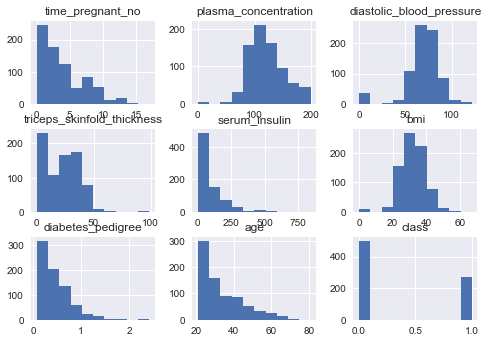

In [95]:
diabetes.hist()

Only categorical variable is target variable, 'class'.

Therefore, this is a classification problem.

In [96]:
zero_counts = (diabetes.drop(['time_pregnant_no','class'], axis=1)==0).sum()
# times pregnant dropped because presumably 0 means never pregnant, not missing values
cols_w_null_vals = diabetes.drop(['time_pregnant_no','class'], axis=1).columns[zero_counts!=0]
100*(diabetes[cols_w_null_vals]==0).sum()/diabetes[cols_w_null_vals].count()

plasma_concentration           0.651042
diastolic_blood_pressure       4.557292
triceps_skinfold_thickness    29.557292
serum_insulin                 48.697917
bmi                            1.432292
dtype: float64

In [97]:
diabetes[cols_w_null_vals].replace(0.,np.nan).describe().round(3)

,plasma_concentration,diastolic_blood_pressure,triceps_skinfold_thickness,serum_insulin,bmi
count,763.000,733.000,541.000,394.000,757.000
mean,121.687,72.405,29.153,155.548,32.457
std,30.536,12.382,10.477,118.776,6.925
min,44.000,24.000,7.000,14.000,18.200
25%,99.000,64.000,22.000,76.250,27.500
50%,117.000,72.000,29.000,125.000,32.300
75%,141.000,80.000,36.000,190.000,36.600
max,199.000,122.000,99.000,846.000,67.100


In [98]:
df = diabetes.copy()
df[cols_w_null_vals] = df[cols_w_null_vals].replace(0.,np.nan)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   time_pregnant_no            768 non-null    int64  
 1   plasma_concentration        763 non-null    float64
 2   diastolic_blood_pressure    733 non-null    float64
 3   triceps_skinfold_thickness  541 non-null    float64
 4   serum_insulin               394 non-null    float64
 5   bmi                         757 non-null    float64
 6   diabetes_pedigree           768 non-null    float64
 7   age                         768 non-null    int64  
 8   class                       768 non-null    int64  
dtypes: float64(6), int64(3)
memory usage: 54.1 KB


## 2. Data Preprocessing and Model
- Assign features to `X` and target variable to `y`
- Create a pipeline for preprocessing which includes imputing and standardscaling
- Create a pipeline for preprocessor and the random forest classifier. Set `n_estimators=100`
- Train the model and make your predictions on the test dataset
- List the feature importance and the corresponding features
- Create a bar plot for the feature importances
- Drop the least important feature from the data and repeat the steps above

In [99]:
def analyze_dat(df, verbose=False, impute_strat = 'median', minmax_counted=False, split_seed=0):
    X = df.drop(['class'], axis=1)
    y = df['class']
    Xtr, Xts, ytr, yts = train_test_split(X, y, stratify=y, random_state=split_seed)

    if minmax_counted: tf_count = MinMaxScaler()
    else: tf_count = StandardScaler()
    tf_meas = Pipeline([
        ('imputer', SimpleImputer(missing_values=np.nan, strategy=impute_strat)),
        ('scaler', StandardScaler())
    ])

    feats = X.columns
    counted_feats = feats[X.dtypes=='int64'] #eg age and num times pregnant
    measured_feats = feats[X.dtypes=='float64']

    preprocessor = ColumnTransformer([
        ('counted', tf_count, counted_feats),
        ('measured', tf_meas, measured_feats)
    ])

    clf = Pipeline([
        ('preprocessor', preprocessor),
        ('estimator', RandomForestClassifier(n_estimators=100))
    ])

    clf.fit(Xtr, ytr)
    clf_score = clf.score(Xts, yts)
    importances = clf.named_steps.estimator.feature_importances_
    if verbose:
        plt.barh(range(len(feats)), importances)
        plt.yticks(range(len(feats)), feats)
        plt.title('Feature Importances')
        print(f'Test Score: {clf_score}')

    least_important_feats = feats[importances==importances.min()].to_list()
    return clf_score, least_important_feats

Test Score: 0.7708333333333334


['serum_insulin']

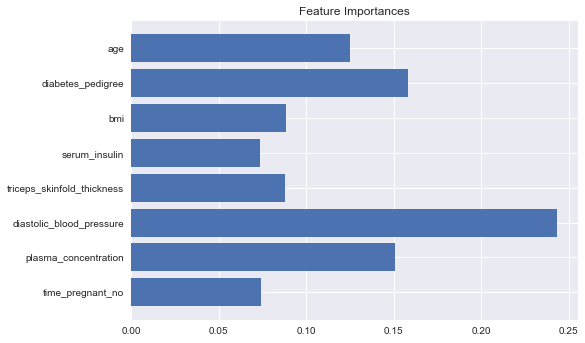

In [100]:
dropfeat1 = analyze_dat(df, verbose=True)[1]
dropfeat1

Test Score: 0.765625


['bmi']

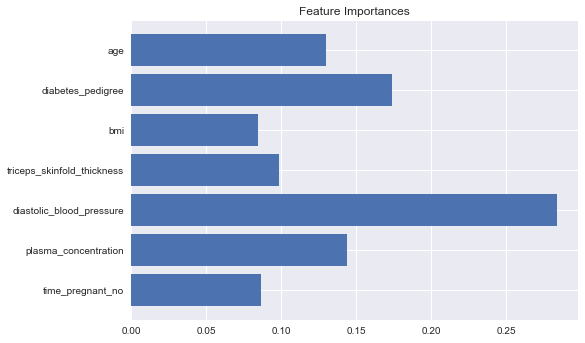

In [101]:
dropfeat2 = analyze_dat(df.drop(dropfeat1, axis=1), verbose=True)[1]
dropfeat2

Test Score: 0.7552083333333334


['time_pregnant_no']

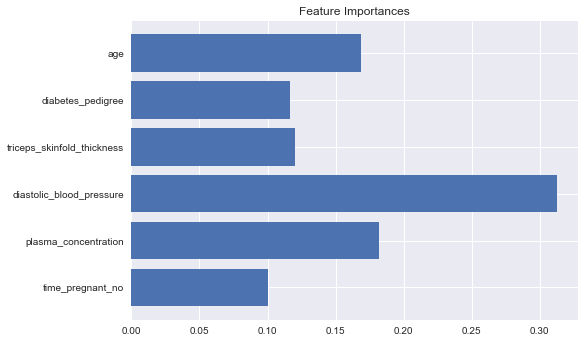

In [102]:
analyze_dat(df.drop(dropfeat2+dropfeat1, axis=1), verbose=True)[1]